# 项目实践，学习一个技能最好的方式就是使用它
# _而评估一个模型的方法就是用它没有训练过的数据来测试_
-----
## **图像分类项目**：<u>[植物品种分类](https://www.kaggle.com/c/plant-seedlings-classification/data)</u>

|plant|
|:---:|
|Black-grass|
|Charlock|
|Cleavers|
|Common Chickweed|
|Common wheat|
|Fat Hen|
|Loose Silky-bent|
|Maize|
|Scentless Mayweed|
|Shepherds Purse|
|Small-flowered Cranesbill|
|Sugar beet|

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from tqdm import tqdm
from os import listdir, makedirs
from os.path import join

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.applications import xception

from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns



def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

def show_image(NUM_CATEGORIES,CATEGORIES):
    fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
    grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
    i = 0
    for category_id, category in enumerate(CATEGORIES):
        for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
            ax = grid[i]
            img = read_img(filepath, (224, 224))
            ax.imshow(img / 255.)
            ax.axis('off')
            if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
                ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
            i += 1
    plt.show();

    
def label2onehot(labels):
#     sess=tf.Session()
    batch_size=tf.size(labels)
    labels_1=tf.expand_dims(labels,1)
    indices=tf.expand_dims(tf.range(0,batch_size),1)
    concated=tf.concat([indices,labels_1],1)
    onehot_labels=tf.sparse_to_dense(concated,tf.stack([batch_size,12]),1.0,0.0)
    return onehot_labels


In [53]:
# Hyperparams if GPU is available
# if tf.test.is_gpu_available():
#     # GPU
#     BATCH_SIZE = 8  # Number of images used in each iteration
#     EPOCHS = 3  # Number of passes through entire dataset
#     print("GPU")
# # Hyperparams for CPU training
# else:
#     # CPU
#     BATCH_SIZE = 4
#     EPOCHS = 1

#设置批量处理数据的大小和轮次
BATCH_SIZE = 8 
EPOCHS = 3 

In [54]:
import os

# 上传 kaggle API token
def get_kaggle_credentials():
    token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
    token_file = os.path.join(token_dir, "kaggle.json")
    if not os.path.isdir(token_dir):
        os.mkdir(token_dir)
    try:
        with open(token_file,'r') as f:
            pass
    except IOError as no_file:
        try:
            from google.colab import files
        except ImportError:
            raise no_file

        uploaded = files.upload()

        if "kaggle.json" not in uploaded:
            raise ValueError("You need an API key! see: "
                           "https://github.com/Kaggle/kaggle-api#api-credentials")
        with open(token_file, "wb") as f:
            f.write(uploaded["kaggle.json"])
        os.chmod(token_file, 600)

get_kaggle_credentials()

### 接口已下载


In [55]:
# 安装kaggle接口
#!pip install kaggle

### 数据已下载并解压

In [56]:
# 下载数据
#!kaggle competitions download -c plant-seedlings-classification
# 解压数据
# !unzip -q train.zip
# !unzip -q test.zip
# !unzip -q sample_submission.csv.zip

In [57]:
SAMPLE_PER_CATEGORY = 200
SEED = 1987

CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
data_dir ='/home/lilingfeng/下载/xiaoxiang/项目1代码/项目代码/项目1-使用tensorflow+Keras构建图像分类模型/项目实践1/'
labels_samples=pd.read_csv(join(data_dir,'sample_submission.csv'))
train_dir = join(data_dir,'train')
test_dir = join(data_dir,'test')
print(train_dir,test_dir)
NUM_CATEGORIES = len(CATEGORIES)
labels_samples.head()



/home/lilingfeng/下载/xiaoxiang/项目1代码/项目代码/项目1-使用tensorflow+Keras构建图像分类模型/项目实践1/train /home/lilingfeng/下载/xiaoxiang/项目1代码/项目代码/项目1-使用tensorflow+Keras构建图像分类模型/项目实践1/test


,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet


# 数据预处理
----
### 各类别的数量统计

In [58]:
for category in CATEGORIES:
    print(category,len(os.listdir(join(train_dir,category))))

Black-grass 263
Charlock 390
Cleavers 287
Common Chickweed 611
Common wheat 221
Fat Hen 475
Loose Silky-bent 654
Maize 221
Scentless Mayweed 516
Shepherds Purse 231
Small-flowered Cranesbill 496
Sugar beet 385


In [59]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape

(4750, 3)

In [60]:
train.head()

,file,category_id,category
0,train/Black-grass/0fe440ed5.png,0,Black-grass
1,train/Black-grass/a8de8a80a.png,0,Black-grass
2,train/Black-grass/807f9b257.png,0,Black-grass
3,train/Black-grass/3f268bcf8.png,0,Black-grass
4,train/Black-grass/f423f84da.png,0,Black-grass


### 看起来数据还比较均衡

In [61]:
(train
 .groupby('category')
 .count()
 .sort_values("category_id")
 .head(12)
)#

,file,category_id
category,,
Common wheat,221,221
Maize,221,221
Shepherds Purse,231,231
Black-grass,263,263
Cleavers,287,287
Sugar beet,385,385
Charlock,390,390
Fat Hen,475,475
Small-flowered Cranesbill,496,496


## training sample
### 由12种类别植物各抽取200类作为训练集

In [62]:
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))

train.shape

(2400, 3)

In [63]:
train.head(10)

,file,category_id,category
0,train/Common Chickweed/fe7373785.png,3,Common Chickweed
1,train/Common Chickweed/7c933aa92.png,3,Common Chickweed
2,train/Charlock/caa43063c.png,1,Charlock
3,train/Fat Hen/52c144a42.png,5,Fat Hen
4,train/Shepherds Purse/ffb54800c.png,9,Shepherds Purse
5,train/Small-flowered Cranesbill/16ecc632f.png,10,Small-flowered Cranesbill
6,train/Sugar beet/c024ba394.png,11,Sugar beet
7,train/Loose Silky-bent/58e87687a.png,6,Loose Silky-bent
8,train/Maize/f9ceba607.png,7,Maize
9,train/Fat Hen/d870ecd2c.png,5,Fat Hen


In [64]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['file_path', 'file'])
test.shape



(794, 2)

In [65]:
test.head()

,file_path,file
0,test/02cfeb38d.png,02cfeb38d.png
1,test/d93c7ab6d.png,d93c7ab6d.png
2,test/32a8c8a1d.png,32a8c8a1d.png
3,test/59358cd44.png,59358cd44.png
4,test/8a8d6c712.png,8a8d6c712.png


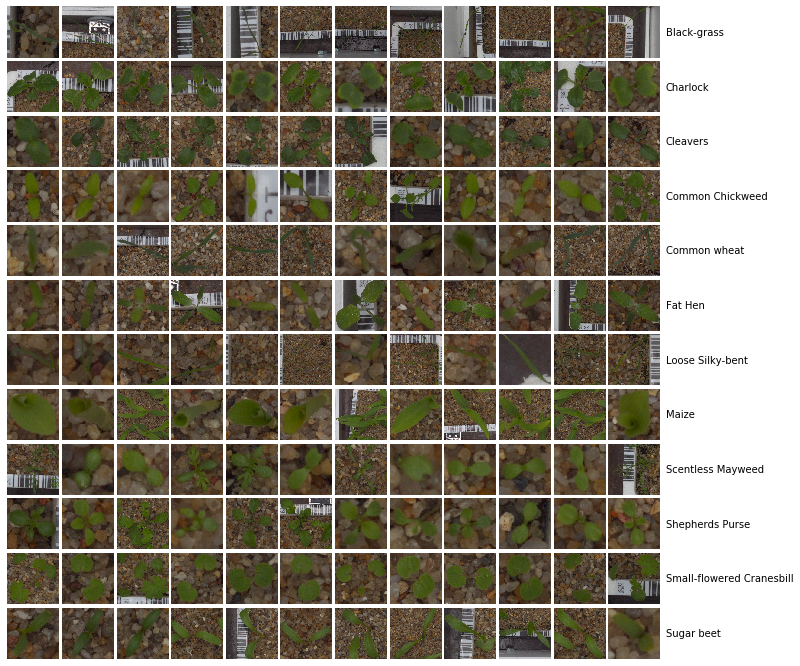

In [66]:
show_image(NUM_CATEGORIES,CATEGORIES)

In [67]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(train))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

(1899, 501)

In [68]:
print(ytr)
print(train_idx,len(train_idx))
print(valid_idx,len(valid_idx))

ytr=label2onehot(list(ytr))
yv=label2onehot(list(yv))
#print(Ytr)
train.head()


[3 3 1 ... 5 3 5]
[ True  True  True ...  True  True  True] 2400
[False False False ... False False False] 2400


,file,category_id,category
0,train/Common Chickweed/fe7373785.png,3,Common Chickweed
1,train/Common Chickweed/7c933aa92.png,3,Common Chickweed
2,train/Charlock/caa43063c.png,1,Charlock
3,train/Fat Hen/52c144a42.png,5,Fat Hen
4,train/Shepherds Purse/ffb54800c.png,9,Shepherds Purse


In [69]:
#将tensor转为numpy数组类型
session = tf.Session()

ytr = session.run(ytr)
yv = session.run(yv)

In [70]:
print(yv)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [71]:
#DATA LOADER
from tensorflow.keras.applications import xception
INPUT_SIZE=299
POOLING='avg'
x_train=np.zeros((len(train),INPUT_SIZE,INPUT_SIZE,3),dtype='float32')
for i,file in tqdm(enumerate(train['file'])):
    img=read_img(file,(INPUT_SIZE,INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print("x_train_shape : ",x_train.shape)

    

2400it [00:28, 83.52it/s] 

x_train_shape :  (2400, 299, 299, 3)


In [72]:

Xtr=x_train[train_idx]
Xv=x_train[valid_idx]



In [73]:
print(Xtr.shape,Xv.shape)
print(len(Xtr))

(1899, 299, 299, 3) (501, 299, 299, 3)
1899


In [74]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Model# Input

base_model = xception.Xception(weights='imagenet', include_top=False)
# 在基模型的基础上添加几层
x = base_model.output
# BN层
x = BatchNormalization()(x)
# 全局池化
x = GlobalAveragePooling2D()(x)
# 添加dropout提高泛化
x = Dropout(0.5)(x)
# 添加全连接增加表达能力
x = Dense(1024, activation='relu')(x)
# 继续dropout
x = Dropout(0.5)(x)
# 分成NUM_CLASSES这么多类
predictions = Dense(NUM_CATEGORIES, activation='softmax')(x)
# 给定“头”和“尾”以定义好整个模型
model = Model(inputs=base_model.input, outputs=predictions)

# 我们把前面的层次固定住(学习率变为0)
for layer in base_model.layers:
    layer.trainable = False
    
# 指定优化器与损失函数，进行编译
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])
    

In [75]:
# Data Loader
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator()

In [76]:
hist = model.fit_generator(train_datagen.flow(Xtr, ytr, batch_size=BATCH_SIZE),
                           steps_per_epoch=train_idx.sum() // BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=test_datagen.flow(Xv, yv, batch_size=BATCH_SIZE),
                           validation_steps=valid_idx.sum() // BATCH_SIZE,
                           verbose=2)

Epoch 1/3
 - 472s - loss: 1.7522 - acc: 0.4469 - val_loss: 2.4320 - val_acc: 0.3246
Epoch 2/3
 - 466s - loss: 1.4934 - acc: 0.5710 - val_loss: 4.6096 - val_acc: 0.2056
Epoch 3/3
 - 467s - loss: 1.4299 - acc: 0.5867 - val_loss: 3.7163 - val_acc: 0.2641


In [77]:
# 评估
test_gen = test_datagen.flow(Xv, yv, batch_size=BATCH_SIZE, shuffle=False)
probabilities = model.predict_generator(test_gen, steps=len(yv)//BATCH_SIZE+1)

In [78]:

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

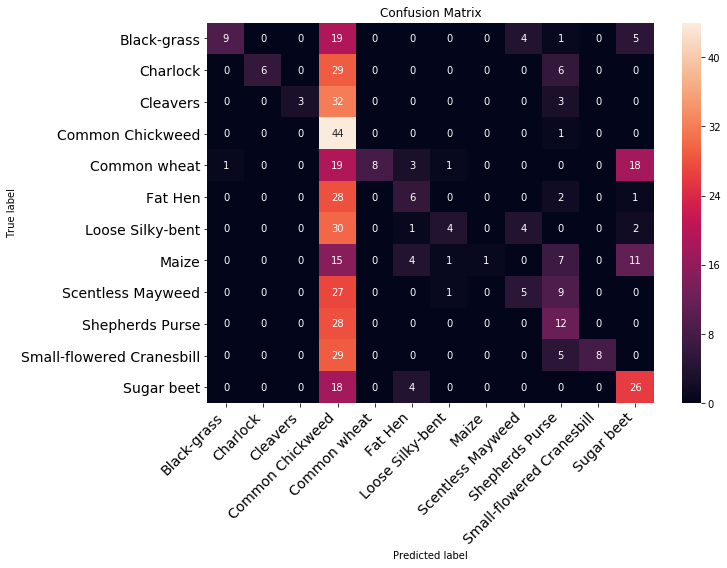

In [86]:
# 绘制多分类混淆矩阵
from sklearn.metrics import confusion_matrix
selected_breed_list = list(train.groupby('category').count().sort_values(by='category_id', ascending=False).head(NUM_CATEGORIES).index)
cnf_matrix = confusion_matrix(np.argmax(yv, axis=1), np.argmax(probabilities,axis=1))
_ = print_confusion_matrix(cnf_matrix, selected_breed_list)

In [87]:
# 打印 Precision-Recall F1-Score的Report
from sklearn.metrics import classification_report

report = classification_report(np.argmax(probabilities,axis=1), np.argmax(yv, axis=1), target_names=selected_breed_list)
print(report)

                           precision    recall  f1-score   support

              Black-grass       0.24      0.90      0.38        10
                 Charlock       0.15      1.00      0.26         6
                 Cleavers       0.08      1.00      0.15         3
         Common Chickweed       0.98      0.14      0.24       318
             Common wheat       0.16      1.00      0.28         8
                  Fat Hen       0.16      0.33      0.22        18
         Loose Silky-bent       0.10      0.57      0.17         7
                    Maize       0.03      1.00      0.05         1
        Scentless Mayweed       0.12      0.38      0.18        13
          Shepherds Purse       0.30      0.26      0.28        46
Small-flowered Cranesbill       0.19      1.00      0.32         8
               Sugar beet       0.54      0.41      0.47        63

                 accuracy                           0.26       501
                macro avg       0.25      0.67      0.25    

In [88]:
# 存储训练得到的模型权重
!mkdir models
model.save_weights('models/tl_xception_weights.h5')